# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [3]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mt
from matplotlib import pyplot as plt

## Cargar datos

In [4]:
# Carga los archivos de datos en diferentes DataFrames
df1_users=pd.read_csv('/datasets/megaline_users.csv')
df2_calls=pd.read_csv('/datasets/megaline_calls.csv')
df3_messages=pd.read_csv('/datasets/megaline_messages.csv')
df4_internet=pd.read_csv('/datasets/megaline_internet.csv')
df5_plans=pd.read_csv('/datasets/megaline_plans.csv')

## Preparar los datos

In [5]:
df1_users.info(show_counts=True)
df2_calls.info(show_counts=True)
df3_messages.info(show_counts=True)
df4_internet.info(show_counts=True)
df5_plans.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
<class 'pandas.core.frame.D

Observe las 5 tablas que vamos a usar en este proyecto de las cuales se vio que solo la primera tabla tiene valores ausentes ademas que hay columnas en algunas tablas que contienen datos con respecto a fechas. Seguire observando en el avance del proyecto sobre si el tipo de datos debe ser cambiado.

## Tarifas

In [6]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df5_plans.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [7]:
# Imprime una muestra de los datos para las tarifas
print(df5_plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


Se pudo observar el detalle de cada plan asi como sus precios; no tiene datos ausentes  pero si podriamos hacer el cambio al tipo de datos de las columnas que involucran pagos a precios a float

### Corregir datos

In [8]:
df5_plans['usd_monthly_pay']=df5_plans['usd_monthly_pay'].astype('float')
df5_plans['usd_per_gb']=df5_plans['usd_per_gb'].astype('float')
df5_plans.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      float64
 4   usd_per_gb             2 non-null      float64
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(4), int64(3), object(1)
memory usage: 256.0+ bytes


### Enriquecer los datos

In [9]:
print(df5_plans.duplicated().sum())

0


## Usuarios/as

In [10]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df1_users.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [11]:
# Imprime una muestra de datos para usuarios
print(df1_users.head())
print(df1_users.describe())

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  
           user_id         age
count   500.000000  500.000000
mean   1249.500000   45.486000
std     144.481833   16.972269
min    1000.000000   18.000000
25%    1124.750000   30.000000
50%    1249.500000   46.000000
75%    1374.250000   61.000000
max    1499.000000   75.000000


Se observo que hay datos ausentes en la columna "churn_date" lo cual es correcto ya que esa columna recibe datos uno vez que el usuario deje de usar el servicio. Ademas se observo que hay columnas que muestras fechas las cuales no tiene como tipo date, para esto se realizara el cambio de tipo de dato a date. el user_id es tipo int lo cual lo cambiare ya que al ser un id no requeriremos hacer operaciones con el por lo cual lo cambiare a uno de tipo object.
Al usar el metodo describe() se puede observar los diferentes calculos matematicos que se puede hacer sobre los valores de edad; consideramos que tenemos 500 clientes, asi como la edad maxima entre ellos es de 75 y entre otros datos.

### Corregir los datos

In [12]:
df1_users['user_id'] = df1_users['user_id'].astype('object')
df1_users['reg_date'] = pd.to_datetime(df1_users['reg_date'], format='%Y-%m-%d')
df1_users['churn_date'] = pd.to_datetime(df1_users['churn_date'], format='%Y-%m-%d')
df1_users.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    object        
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 31.4+ KB


### Enriquecer los datos

In [13]:
print(df1_users.duplicated().sum())

0


## Llamadas

In [14]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df2_calls.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [15]:
# Imprime una muestra de datos para las llamadas
print(df2_calls.head())
print(df2_calls.describe())

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22
             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290000
50%      1247.000000       5.980000
75%      1365.000000      10.690000
max      1499.000000      37.600000


El tipo de dato en la columna "user_id" se cambiara a tipo object y la columna "call_date" al se una columna que almacena datos de fechas sera cambiada a tipo date.
Al usar el metodo describe() se puede observar los diferentes calculos matematicos que se puede hacer sobre los valores de duracion de llamada; consideramos que tenemos 500 clientes, asi como la llamada con el maximo tiempo es de casi 38 minutos, etc

### Corregir los datos

In [16]:
df2_calls['user_id'] = df2_calls['user_id'].astype('object')
df2_calls['call_date'] = pd.to_datetime(df2_calls['call_date'], format='%Y-%m-%d')
df2_calls.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  object        
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.2+ MB


### Enriquecer los datos

In [17]:
df2_calls['call_month'] = df2_calls['call_date'].dt.to_period('M')
print(df2_calls.duplicated().sum())

0


## Mensajes

In [18]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df3_messages.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [19]:
# Imprime una muestra de datos para los mensajes
print(df3_messages.head())

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


Se observo que tenemos una columna "message_date" que contiene datos de tipo fecha por lo cual lo cambiaremos a tipo date y "user_id" lo cambiaremos a tipo object y al final se validara si rtenemos duplicidad de datos.

### Corregir los datos

In [20]:
df3_messages['user_id'] = df3_messages['user_id'].astype('object')
df3_messages['message_date'] = pd.to_datetime(df3_messages['message_date'], format='%Y-%m-%d')
df3_messages.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  object        
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


### Enriquecer los datos

In [21]:
df3_messages['message_month'] = df3_messages['message_date'].dt.to_period('M')
print(df3_messages.duplicated().sum())

0


## Internet

In [22]:
# Imprime la información general/resumida sobre el DataFrame de internet
df4_internet.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [23]:
# Imprime una muestra de datos para el tráfico de internet
print(df4_internet.head())
print(df4_internet.describe())

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22
             user_id        mb_used
count  104825.000000  104825.000000
mean     1242.496361     366.713701
std       142.053913     277.170542
min      1000.000000       0.000000
25%      1122.000000     136.080000
50%      1236.000000     343.980000
75%      1367.000000     554.610000
max      1499.000000    1693.470000


Se verifico que tenemos datos de tipo fecha en la columna session_date que son de tipo object por lo cual estos seran cambiados a tipo date. Usando el metodo describe() pudimos identificar datos sobre el total de mb consumidos por todos los clientes asi como cual fue el consumo mayor realizado

### Corregir los datos

In [24]:
df4_internet['user_id'] = df4_internet['user_id'].astype('object')
df4_internet['session_date'] = pd.to_datetime(df4_internet['session_date'], format='%Y-%m-%d')
df4_internet.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  object        
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.2+ MB


### Enriquecer los datos

In [25]:
df4_internet['session_month'] = df4_internet['session_date'].dt.to_period('M')
print(df4_internet.duplicated().sum())

0


## Estudiar las condiciones de las tarifas

In [26]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print(df5_plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0             20.0        10.0             0.03            0.03      surf  
1             70.0         7.0             0.01            0.01  ultimate  


## Agregar datos por usuario

In [27]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
#df2_calls['call_month'] = df2_calls['call_date'].dt.to_period('M')
call_user_month = df2_calls.groupby(['user_id','call_month']).size().reset_index(name='count_call')
#print(df2_calls)
print(call_user_month)

      user_id call_month  count_call
0        1000    2018-12          16
1        1001    2018-08          27
2        1001    2018-09          49
3        1001    2018-10          65
4        1001    2018-11          64
...       ...        ...         ...
2253     1498    2018-12          39
2254     1499    2018-09          41
2255     1499    2018-10          53
2256     1499    2018-11          45
2257     1499    2018-12          65

[2258 rows x 3 columns]


In [28]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
call_user_minute = df2_calls.groupby(['user_id','call_month'])['duration'].sum().reset_index(name='total_minutes')
#print(df2_calls)
print(call_user_minute)

      user_id call_month  total_minutes
0        1000    2018-12         116.83
1        1001    2018-08         171.14
2        1001    2018-09         297.69
3        1001    2018-10         374.11
4        1001    2018-11         404.59
...       ...        ...            ...
2253     1498    2018-12         324.77
2254     1499    2018-09         330.37
2255     1499    2018-10         363.28
2256     1499    2018-11         288.56
2257     1499    2018-12         468.10

[2258 rows x 3 columns]


In [29]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
#df3_messages['message_month'] = df3_messages['message_date'].dt.to_period('M')
message_user_month = df3_messages.groupby(['user_id','message_month']).size().reset_index(name='number_message')
#print(df3_messages)
print(message_user_month)

      user_id message_month  number_message
0        1000       2018-12              11
1        1001       2018-08              30
2        1001       2018-09              44
3        1001       2018-10              53
4        1001       2018-11              36
...       ...           ...             ...
1801     1496       2018-09              21
1802     1496       2018-10              18
1803     1496       2018-11              13
1804     1496       2018-12              11
1805     1497       2018-12              50

[1806 rows x 3 columns]


In [38]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
#df4_internet['session_month'] = df4_internet['session_date'].dt.to_period('M')
internet_user_month = df4_internet.groupby(['user_id','session_month'])['mb_used'].sum().reset_index(name='volum_trafic_internet')
internet_user_month['volum_trafic_internet_GB']=(internet_user_month['volum_trafic_internet']/1024)
internet_user_month['volum_trafic_internet_GB_redondeo']=np.ceil(internet_user_month['volum_trafic_internet_GB']).astype(int)
print(internet_user_month)

      user_id session_month  volum_trafic_internet  volum_trafic_internet_GB  \
0        1000       2018-12                1901.47                  1.856904   
1        1001       2018-08                6919.15                  6.756982   
2        1001       2018-09               13314.82                 13.002754   
3        1001       2018-10               22330.49                 21.807119   
4        1001       2018-11               18504.30                 18.070605   
...       ...           ...                    ...                       ...   
2272     1498       2018-12               23137.69                 22.595400   
2273     1499       2018-09               12984.76                 12.680430   
2274     1499       2018-10               19492.43                 19.035576   
2275     1499       2018-11               16813.83                 16.419756   
2276     1499       2018-12               22059.21                 21.542197   

      volum_trafic_internet_GB_redondeo

In [39]:
#[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
call_user_month.rename(columns={'call_month': 'month'}, inplace=True)
call_user_minute.rename(columns={'call_month': 'month'}, inplace=True)
message_user_month.rename(columns={'message_month': 'month'}, inplace=True)
internet_user_month.rename(columns={'session_month': 'month'}, inplace=True)
df_fusion = call_user_month.merge(call_user_minute, on=['user_id','month']).merge(message_user_month, on=['user_id','month']).merge(internet_user_month, on=['user_id','month'])
df_fusion_v = call_user_month.merge(call_user_minute, how='outer', on=['user_id','month']).merge(message_user_month, how='outer', on=['user_id','month']).merge(internet_user_month, how='outer', on=['user_id','month'])
print(df_fusion_v)

      user_id    month  count_call  total_minutes  number_message  \
0        1000  2018-12        16.0         116.83            11.0   
1        1001  2018-08        27.0         171.14            30.0   
2        1001  2018-09        49.0         297.69            44.0   
3        1001  2018-10        65.0         374.11            53.0   
4        1001  2018-11        64.0         404.59            36.0   
...       ...      ...         ...            ...             ...   
2288     1349  2018-12         NaN            NaN            61.0   
2289     1361  2018-05         NaN            NaN             2.0   
2290     1482  2018-10         NaN            NaN             2.0   
2291     1108  2018-12         NaN            NaN             NaN   
2292     1311  2018-06         NaN            NaN             NaN   

      volum_trafic_internet  volum_trafic_internet_GB  \
0                   1901.47                  1.856904   
1                   6919.15                  6.756982   


In [40]:
# Añade la información de la tarifa
df_tarifa=df1_users[['user_id','plan']].copy()
df_fusion['user_id'] = df_fusion['user_id'].astype(object)
df_tarifa['user_id'] = df_tarifa['user_id'].astype(object)
df_fusion_tarifa = df_fusion.merge(df_tarifa, on='user_id', how='left')
#print(df_tarifa.head())
#print(df_fusion.head())
print(df_fusion_tarifa)

     user_id    month  count_call  total_minutes  number_message  \
0       1000  2018-12          16         116.83              11   
1       1001  2018-08          27         171.14              30   
2       1001  2018-09          49         297.69              44   
3       1001  2018-10          65         374.11              53   
4       1001  2018-11          64         404.59              36   
...      ...      ...         ...            ...             ...   
1754    1496  2018-09          52         389.94              21   
1755    1496  2018-10          46         301.16              18   
1756    1496  2018-11          39         291.88              13   
1757    1496  2018-12          40         278.61              11   
1758    1497  2018-12          54         276.53              50   

      volum_trafic_internet  volum_trafic_internet_GB  \
0                   1901.47                  1.856904   
1                   6919.15                  6.756982   
2           

In [41]:
# Calcula el ingreso mensual para cada usuario
def calcular_ingreso(dataframe):
    total_mes = []
    for index, row in dataframe.iterrows():
        plan = row['plan']
        total_minutes = mt.ceil(row['total_minutes'])
        number_message = row['number_message']
        volumen_mb = row['volum_trafic_internet']
        volumen_gb = mt.ceil(volumen_mb / 1024)
        total_ingreso = 0
        if plan == 'surf':
            tarifa_mensual = 20
            exceso_min = max(0,total_minutes-500)
            exceso_sms = max(0,number_message-50)
            exceso_gb = max(0,volumen_gb-15)
            total_ingreso = tarifa_mensual+(exceso_min*0.03)+(exceso_sms*0.03)+(exceso_gb*10)
        elif plan == 'ultimate':
            tarifa_mensual = 70
            exceso_min = max(0,total_minutes-3000)
            exceso_sms = max(0,number_message-1000)
            exceso_gb = max(0,volumen_gb-30)
            total_ingreso = tarifa_mensual+(exceso_min*0.01)+(exceso_sms*0.01)+(exceso_gb*7)
        total_mes.append(total_ingreso)
    dataframe['pago_mes'] = total_mes
    return dataframe
df_consolidado_mes= calcular_ingreso(df_fusion_tarifa)
print(df_consolidado_mes)

     user_id    month  count_call  total_minutes  number_message  \
0       1000  2018-12          16         116.83              11   
1       1001  2018-08          27         171.14              30   
2       1001  2018-09          49         297.69              44   
3       1001  2018-10          65         374.11              53   
4       1001  2018-11          64         404.59              36   
...      ...      ...         ...            ...             ...   
1754    1496  2018-09          52         389.94              21   
1755    1496  2018-10          46         301.16              18   
1756    1496  2018-11          39         291.88              13   
1757    1496  2018-12          40         278.61              11   
1758    1497  2018-12          54         276.53              50   

      volum_trafic_internet  volum_trafic_internet_GB  \
0                   1901.47                  1.856904   
1                   6919.15                  6.756982   
2           

Se lo indentificar cual es el pago que realiza el usuario al mes por el plan y servicios que adquirio; se pudo observar que hay usuarios que realizan el pago correspondiente al plan adquirido pero de la misma forma se observa que hay usuarios que pagan montos mayores al de su plan ya que hicieron uso de los servicios adicionales los cuales incorporo su pago del mes.

## Estudia el comportamiento de usuario

### Llamadas

plan           surf    ultimate
month                          
2018-01  278.850000  187.453333
2018-02  313.240000  458.316000
2018-03  324.985625  389.648571
2018-04  346.206286  303.301250
2018-05  418.675283  387.340952
2018-06  401.525429  349.536757
2018-07  426.454382  415.912979
2018-08  404.183950  411.488246
2018-09  402.010068  413.126479
2018-10  417.628785  438.700795
2018-11  418.942202  438.496569
2018-12  467.447073  436.801040


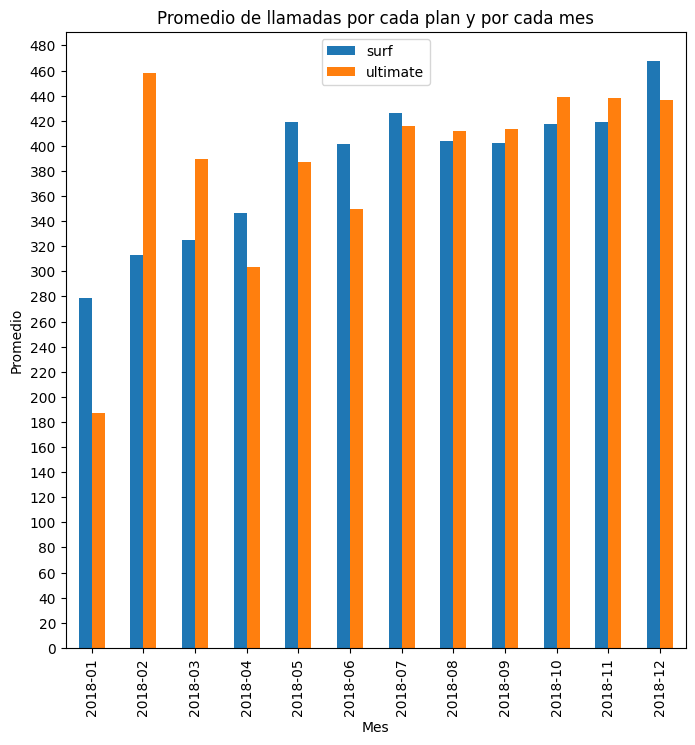

In [42]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
llamadas=df_consolidado_mes.groupby(['plan','month'])['total_minutes'].mean().reset_index(name='promedio')
pivot=llamadas.pivot_table(index='month', columns='plan', values='promedio')
print(pivot)
pivot.plot(
    title='Promedio de llamadas por cada plan y por cada mes',
    xlabel='Mes',
    ylabel='Promedio',
    kind='bar',
    figsize=[8,8],
    yticks=range(0,490,20),
)
plt.legend(['surf','ultimate'])
plt.show()


plan          surf  ultimate
month                       
2018-01     278.85    562.36
2018-02    1566.20   2291.58
2018-03    5199.77   2727.54
2018-04   12117.22   4852.82
2018-05   22189.79   8134.16
2018-06   28106.78  12932.86
2018-07   37954.44  19547.91
2018-08   48097.89  23454.83
2018-09   59095.48  29331.98
2018-10   75590.81  38605.67
2018-11   91329.40  44726.65
2018-12  114991.98  54600.13


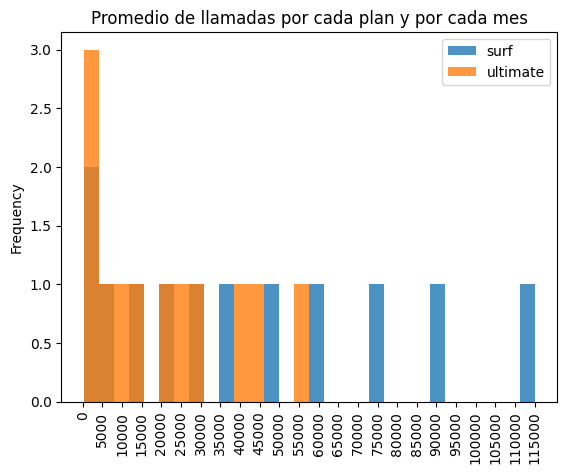

In [43]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
#print(df_consolidado_mes)
llamadas=df_consolidado_mes.groupby(['plan','month'])['total_minutes'].sum().reset_index(name='suma')
pivot=llamadas.pivot_table(index='month', columns='plan', values='suma')
print(pivot)
pivot.plot(
    title='Promedio de llamadas por cada plan y por cada mes',
    xlabel='Mes',
    ylabel='Promedio',
    kind='hist',
    bins=30,
    alpha=0.8,
    xticks=range(0,120000,5000),
    rot=90
)
plt.legend(['surf','ultimate'])
plt.show()


In [45]:
# Calcula la media y la varianza de la duración mensual de llamadas.
#print(df_consolidado_mes)
media_plan = df_consolidado_mes.groupby('plan')['total_minutes'].mean()
varianza_plan = df_consolidado_mes.groupby('plan')['total_minutes'].var()

print("Media por plan:")
print(media_plan)
print("\nVarianza por plan:")
print(varianza_plan)
print("\nvalores estadisticos:")
print(df_consolidado_mes.describe())

Media por plan:
plan
surf        420.778483
ultimate    417.562159
Name: total_minutes, dtype: float64

Varianza por plan:
plan
surf        49492.562612
ultimate    55607.233145
Name: total_minutes, dtype: float64

valores estadisticos:
        count_call  total_minutes  number_message  volum_trafic_internet  \
count  1759.000000    1759.000000     1759.000000            1759.000000   
mean     62.226265     419.719784       41.782831           16833.751097   
std      32.838072     226.885639       32.673455            7708.682398   
min       1.000000       0.000000        1.000000              92.310000   
25%      40.000000     261.550000       17.000000           12524.640000   
50%      61.000000     409.110000       34.000000           16867.460000   
75%      81.000000     552.135000       59.000000           20911.990000   
max     205.000000    1431.220000      266.000000           70931.590000   

       volum_trafic_internet_GB  volum_trafic_internet_GB_redondeo  \
count   

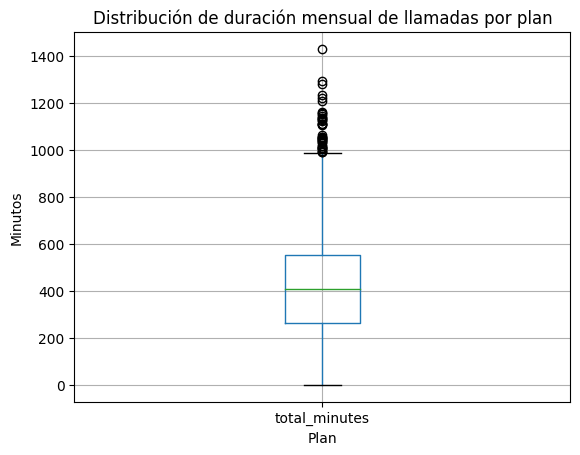

In [85]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
df_consolidado_mes.boxplot(column='total_minutes')
plt.title('Distribución de duración mensual de llamadas por plan')
plt.xlabel('Plan')
plt.ylabel('Minutos')
plt.grid(True)
plt.yticks=range(0,1500,100)
plt.show()


Los usuarios realizan llamadas alrededor de 400 minutos, lo que indica que la mitad de los usuarios hablan menos de 400 minutos al mes, y la otra mitad más de ese tiempo; tambien se observa que hay usuarios que realizan llamadas de 0 minutos siendo una menor cantidad asi tambien tenemos llamadas desde 1000 hasta mayores de 1400 minutos

### Mensajes

plan      surf  ultimate
month                   
2018-01     21        62
2018-02    108       139
2018-03    351       243
2018-04    864       463
2018-05   1778       931
2018-06   2292      1374
2018-07   3096      1937
2018-08   4439      2732
2018-09   5672      3259
2018-10   7507      4179
2018-11   8739      4861
2018-12  11731      6718


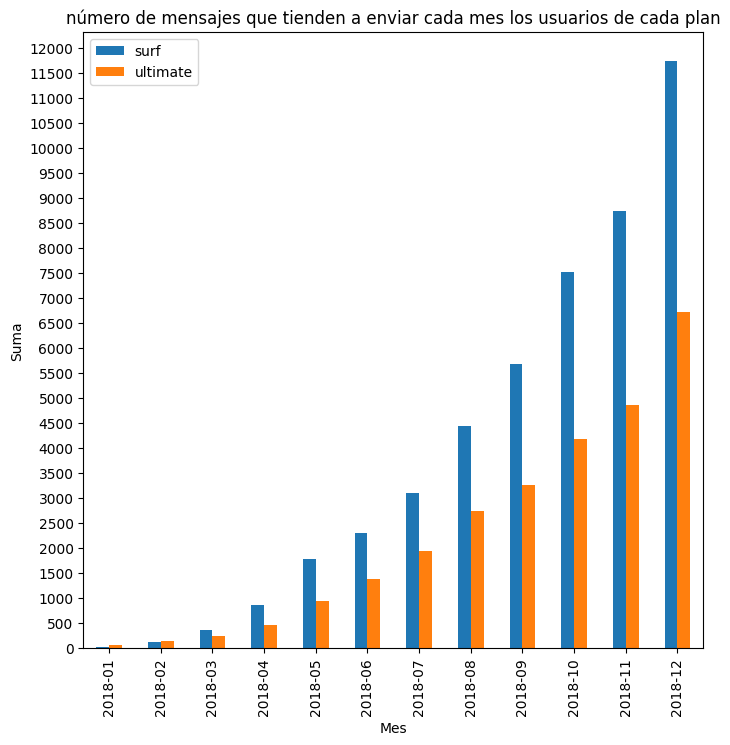

In [86]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
#print(df_consolidado_mes.head(20))
mensajes=df_consolidado_mes.groupby(['plan','month'])['number_message'].sum().reset_index(name='suma')
pivot_sms=mensajes.pivot_table(index='month', columns='plan', values='suma')
print(pivot_sms)
pivot_sms.plot(
    title='número de mensajes que tienden a enviar cada mes los usuarios de cada plan',
    xlabel='Mes',
    ylabel='Suma',
    kind='bar',
    figsize=[8,8],
    yticks=range(0,12001,500),
)
plt.legend(['surf','ultimate'])
plt.show()


plan          surf  ultimate
user_id                     
1000           NaN   1901.47
1001      80437.94       NaN
1002      40293.33       NaN
1003      27044.14       NaN
1004     156352.81       NaN
...            ...       ...
1491      63050.67       NaN
1492      40823.96       NaN
1494      91389.19       NaN
1496      64268.64       NaN
1497           NaN  11106.55

[393 rows x 2 columns]


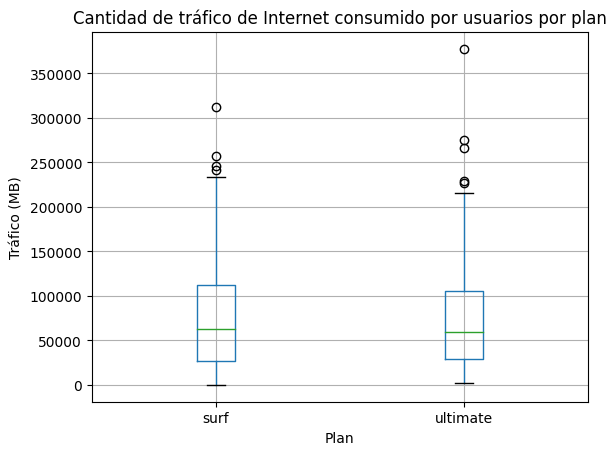

In [95]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
#print(df_consolidado_mes.head())
traf_internet=df_consolidado_mes.groupby(['plan','user_id'])['volum_trafic_internet'].sum().reset_index(name='trafico')
pivot_inter=traf_internet.pivot_table(index='user_id', columns='plan', values='trafico')
print(pivot_inter)

pivot_inter.boxplot(column=['surf', 'ultimate'])
plt.title('Cantidad de tráfico de Internet consumido por usuarios por plan')
plt.xlabel('Plan')
plt.ylabel('Tráfico (MB)')
plt.grid(True)
plt.show()

El uso de sms en el plan surf es superior con respecto al plan ultime ya que se ve un consumo mayor, el consumo al pasar de los meses va creciendo teniendo en el mes 12 del 2018 el consumo mas elevado de mensajes.

### Internet

plan           surf    ultimate
month                          
2018-01     7894.79    20859.60
2018-02    46553.82    86678.78
2018-03   198357.48   166850.06
2018-04   414788.20   228572.67
2018-05   787125.24   356864.13
2018-06  1089602.03   571687.82
2018-07  1487064.36   775468.24
2018-08  2042246.69  1024688.05
2018-09  2424433.25  1165149.16
2018-10  3150526.25  1541075.29
2018-11  3553434.74  1767022.06
2018-12  4420214.74  2283410.73


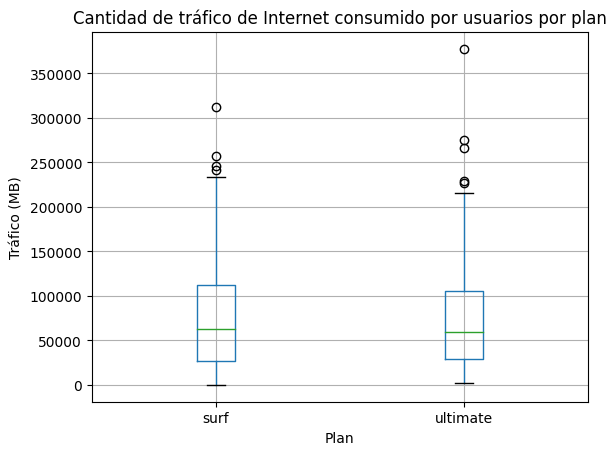

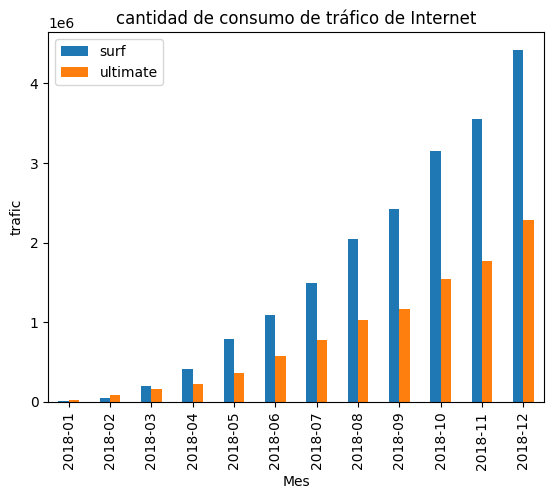

In [97]:
#print(df_consolidado_mes)
internet=df_consolidado_mes.groupby(['plan','month'])['volum_trafic_internet'].sum().reset_index(name='net')
pivot_net=internet.pivot_table(index=['month'], columns='plan', values='net')
print(pivot_net)

pivot_inter.boxplot(column=['surf', 'ultimate'])
plt.title('Cantidad de tráfico de Internet consumido por usuarios por plan')
plt.xlabel('Plan')
plt.ylabel('Tráfico (MB)')
plt.grid(True)
plt.show()

pivot_net.plot(
    title='cantidad de consumo de tráfico de Internet',
    xlabel='Mes',
    ylabel='trafic',
    kind='bar',
    #figsize=[8,8],
    #yticks=range(0,12001,500),
)
plt.legend(['surf','ultimate'])
plt.show()

Se tiene un consumo mucho mayor en el plan surf con respecto al plan ultimate, siendo el mes 12 del 2018 donde se genera mas consumo; este se ve de forma creciente desde el mes 1 hasta el mes 12 del 2018.

## Ingreso

plan         surf  ultimate
month                      
2018-01     20.00     210.0
2018-02    118.34     350.0
2018-03    613.23     546.0
2018-04   1409.36    1169.0
2018-05   2669.66    1491.0
2018-06   3622.81    2667.0
2018-07   5460.90    3402.0
2018-08   7618.36    4130.0
2018-09   8358.17    5068.0
2018-10  11761.92    6349.0
2018-11  12365.26    7357.0
2018-12  16799.22    9093.0
plan           surf     ultimate
count     12.000000    12.000000
mean    5901.435833  3486.000000
std     5525.817934  2966.079782
min       20.000000   210.000000
25%     1210.327500  1013.250000
50%     4541.855000  3034.500000
75%     9209.107500  5388.250000
max    16799.220000  9093.000000


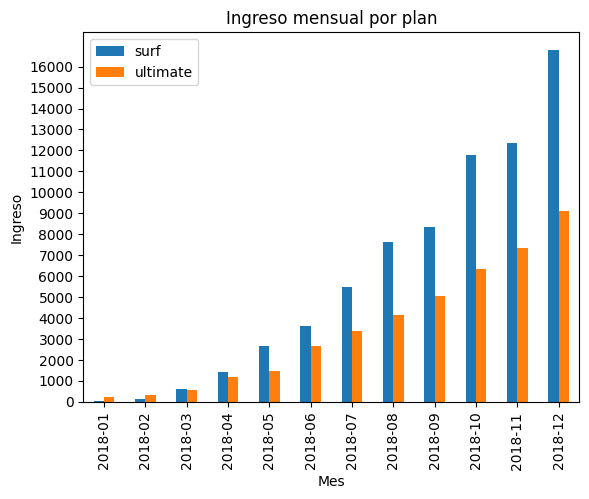

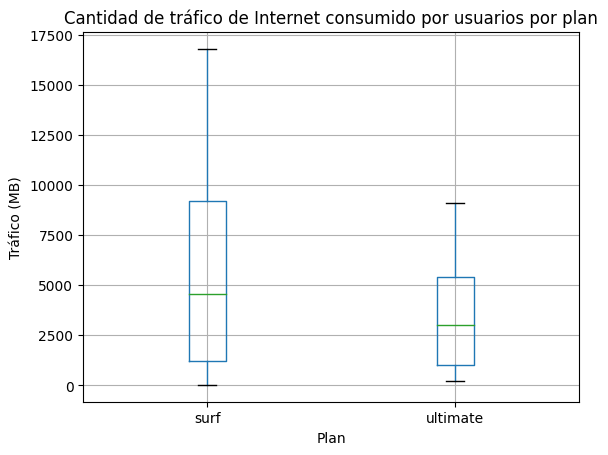

In [102]:
#print(df_consolidado_mes)
ingreso=df_consolidado_mes.groupby(['plan','month'])['pago_mes'].sum().reset_index(name='ingreso')
pivot_ing=ingreso.pivot_table(index=['month'], columns='plan', values='ingreso')
print(pivot_ing)
print(pivot_ing.describe())

pivot_ing.plot(
    title='Ingreso mensual por plan',
    xlabel='Mes',
    ylabel='Ingreso',
    kind='bar',
    #figsize=[8,8],
    yticks=range(0,17000,1000),
)
plt.legend(['surf','ultimate'])
plt.show()

pivot_ing.boxplot(column=['surf', 'ultimate'])
plt.title('Cantidad de tráfico de Internet consumido por usuarios por plan')
plt.xlabel('Plan')
plt.ylabel('Tráfico (MB)')
plt.grid(True)
plt.show()


El plan de surf tiene mayores ingresos son respecto al plan ultimate; los 2 primeros meses el plan surf es inferior a ultimate mas desde el tercer mes hasta el doceavo se ve que va se forma creciente, llevandose po una gran diferencia al total.

## Prueba las hipótesis estadísticas

In [46]:
# Prueba las hipótesis
#print(df_consolidado_mes)

ingresos_ultimate = df_consolidado_mes[df_consolidado_mes['plan'] == 'ultimate']['pago_mes']
ingresos_surf = df_consolidado_mes[df_consolidado_mes['plan'] == 'surf']['pago_mes']

stat_levene, p_levene = st.levene(ingresos_ultimate, ingresos_surf)
print("Valor p de Levene (igualdad de varianzas):", p_levene)

p_value = st.ttest_ind(ingresos_ultimate, ingresos_surf, equal_var=False)
print('Valor p:', p_value.pvalue)

alpha = 0.05
if p_value.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


Valor p de Levene (igualdad de varianzas): 2.5914843897925543e-69
Valor p: 8.319558977074422e-14
Rechazamos la hipótesis nula


determinamos que los ingresos promedio entre los planes Ultimate y Surf son diferentes.

In [47]:
# Prueba las hipótesis
pagos_filt = df_consolidado_mes.groupby('user_id')['pago_mes'].sum().reset_index()
filt=df1_users[['user_id','city','plan']]
filt[['ciudad', 'condado']] = filt['city'].str.split(',', expand=True)
filtro_ciudad=filt[['user_id','ciudad','plan']].copy()
union=pagos_filt.merge(filtro_ciudad, on='user_id')
#print(union)

ingresos_filtro = union[union['ciudad'] == 'New York-Newark-Jersey City']['pago_mes']
ingresos_otros = union[union['ciudad'] != 'New York-Newark-Jersey City']['pago_mes']

stat_levene, p_levene = st.levene(ingresos_filtro, ingresos_otros)
print("Valor p de Levene (igualdad de varianzas):", p_levene)

p_value = st.ttest_ind(ingresos_filtro, ingresos_otros, equal_var=False)

print('Valor p:', p_value.pvalue)

alpha = 0.05
if p_value.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


Valor p de Levene (igualdad de varianzas): 0.375638151155947
Valor p: 0.17684838034423503
No podemos rechazar la hipótesis nula


/.venv/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Los ingresos promedios varian entre los usuarios del área New York-Newark-Jersey City NY - NY y los usuarios de otras regiones.

## Conclusión general
La limpieza de los datos fue importante para lueg poder realizar los ejercicios.
Se puso observar que hay mas clientes que adquiere el plan surf el cual genera mayores ingresos a comparacion del plan ultimate que a pesar de ser un buen plan no se aproxima a los ingresos del plan surf
En cuanto al promedio de llamadas realizadas en ambos planes si pudo observar variaciones en los meses y al consumo promedio de llamadas por plan y por periodo de tiempo, por lo cual identificamos que el uso de llamas en ambos planes puede variar con respecto al mes.